# Lab2 - Trie & Suffix tree
Jakub Karbowski

In [2]:
import Pkg
Pkg.add([
    "BenchmarkTools",
    "Plots",
    "GraphRecipes",
])

using BenchmarkTools: BenchmarkTools, @belapsed
import Plots: plot
using GraphRecipes: graphplot
import Base: occursin, push!

BenchmarkTools.DEFAULT_PARAMETERS.seconds = 0.01
;

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [3]:
data = [
    "bbb0",
    # Mogło być bbb$,
    # ale biblioteka do rysowania
    # grafów używa $ do czegoś specjalnego.
    "aabbabd",
    "ababcd",
    "abcbccd",
]

4-element Vector{String}:
 "bbb0"
 "aabbabd"
 "ababcd"
 "abcbccd"

# Tree plots
Trochę rysowania.

In [4]:
abstract type AbstractSuffixTree end

function plot(t::T) where T<:AbstractSuffixTree
    nverts = 1
    edges = []
    labels = Dict()
    
    function process(node, id)
        for (edge, child) = suffixchildren(node)
            nverts += 1
            cid = nverts
            push!(edges, (id, cid))
            labels[(id, cid)] = edge
            process(child, cid)
        end
    end
    
    process(t, 1)
    
    G = falses(nverts, nverts)
    for (u, v) = edges
        G[u,v] = 1
    end
    
    graphplot(G,
        edgelabel=labels,
        curves=false,
        method=:tree,
    )
end
;

# Trie
Head & graft.

Budowa: $O(n^2)$

Rozmiar: $O(n^2)$

text = "banana0"
occursin("abc", t) = false
occursin("bca", t) = false


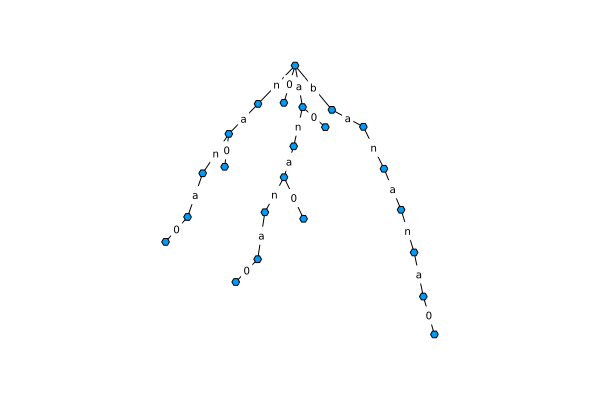

In [5]:
struct Trie{T} <: AbstractSuffixTree
    children::Dict{T, Trie}
end

Trie(::Type{T}) where T = Trie(Dict{T, Trie}())

suffixchildren(t::Trie) = t.children

function Trie(text)
    root = Trie(eltype(text))
    # add every suffix
    for i = 1:length(text)
        suf = @view text[i:end]
        node = root
        for c = suf
            # follow existing edges
            # or add new
            if !haskey(node.children, c)
                node.children[c] = Trie(eltype(text))
            end
            node = node.children[c]
        end
    end
    root
end

function occursin(text, trie::Trie)
    node = trie
    for c = text
        if !haskey(node.children, c)
            return false
        end
        node = node.children[c]
    end
    true
end

# text = data[3]
text = "banana0"
@show text
t = Trie(text)
@show occursin("abc", t)
@show occursin("bca", t)
plot(t)

# Suffix tree
Tak jak trie, ale krawędzie to referencje
do wycinków tekstu.
Algorytm porusza się po wirtualnych
wierzchołkach identyfikowanych
przez parenta, pierwszą literę krawędzi
oraz indeks w krawędzi.

Budowa: $O(n^2)$

Rozmiar: $O(n)$

text = "banana0"
occursin("nana", t) = true
occursin("naa", t) = false


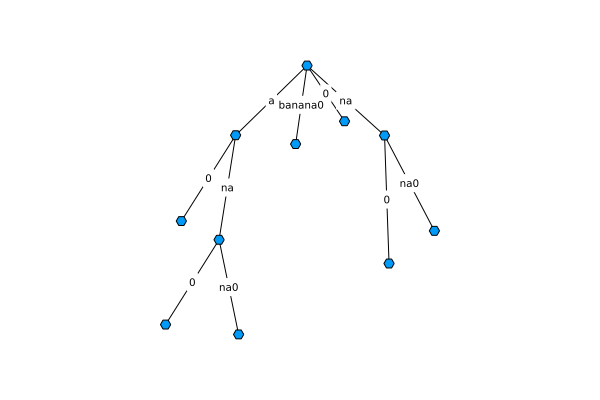

In [18]:
struct SuffTree <: AbstractSuffixTree
    # Krawędź to wycinek tekstu (przez referencję).
    # Kluczem jest pierwszy znak krawędzi.
    children::Dict{Char, Tuple{SubString{String}, SuffTree}}
end

SuffTree() = SuffTree(Dict{Char, Tuple{SubString{String}, SuffTree}}())

suffixchildren(t::SuffTree) = values(t.children)

function SuffTree(text::String)
    root = SuffTree()
    # dodaj każdy suffix (przez referencję dzięki @view)
    for i = 1:length(text)
        push!(root, @view text[i:end])
    end
    root
end

# insert suffix
function push!(t::SuffTree, suf::SubString{String})
    node = t
    onedge = false
    edgechar = nothing
    edgematched = nothing
    sufmatched = 0
    while sufmatched < length(suf)
        if !onedge
            if haskey(node.children, suf[sufmatched + 1])
                # jump to existing edge
                onedge = true
                edgechar = suf[sufmatched + 1]
                edgematched = 1
                sufmatched += 1
            else
                # graft suffix remainder as new edge
                node.children[suf[sufmatched + 1]] = (suf[sufmatched + 1:end], SuffTree())
                break
            end
        else
            if node.children[edgechar][1][edgematched + 1] == suf[sufmatched + 1]
                # follow current edge
                edgematched += 1
                sufmatched += 1
            else # mismatch on edge
                # split edge
                
                child = node.children[edgechar][2]
                
                # branching node
                newnode = SuffTree()
                
                # old connection
                newnode.children[node.children[edgechar][1][edgematched + 1]] =
                    (node.children[edgechar][1][edgematched + 1:end], child)
                
                # graft suffix remainder
                newnode.children[suf[sufmatched + 1]] = (suf[sufmatched + 1:end], SuffTree())
                
                # reconnect
                node.children[edgechar] = (node.children[edgechar][1][1:edgematched], newnode)
                
                break
            end
        end
        
        # if reached end of current edge
        if edgematched == length(node.children[edgechar][1])
            # jump to next node
            node = node.children[edgechar][2]
            onedge = false
            edgematched = nothing
            edgechar = nothing
        end
    end
end

function occursin(text, t::SuffTree)
    node = t
    onedge = false
    edgechar = nothing
    edgematched = nothing
    textmatched = 0
    while textmatched < length(text)
        if !onedge
            if haskey(node.children, text[textmatched + 1])
                # jump to existing edge
                onedge = true
                edgechar = text[textmatched + 1]
                edgematched = 1
                textmatched += 1
            else
                return false
            end
        else
            if node.children[edgechar][1][edgematched + 1] == text[textmatched + 1]
                # follow current edge
                edgematched += 1
                textmatched += 1
            else
                return false
            end
        end
        
        # if reached end of current edge
        if edgematched == length(node.children[edgechar][1])
            # jump to next node
            node = node.children[edgechar][2]
            onedge = false
            edgematched = nothing
            edgechar = nothing
        end
    end
    true
end

text = "banana0"
@show text
t = SuffTree(text)
@show occursin("nana", t)
@show occursin("naa", t)
plot(t)

# Bench
Suffix tree jest o wiele szybszy (razy stały współczynnik).
Oba algorytmy mają jednak czas $O(n^2)$.

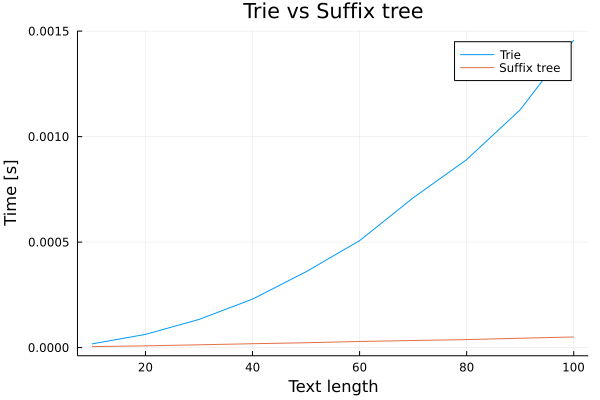

In [7]:
function bench(n, builder)
    text = String(rand('a':'z', n)) * "0"
    @belapsed $builder($text)
end
n = 10:10:100
times = [
    bench.(n, Trie),
    bench.(n, SuffTree),
]
plot(
    n,
    times,
    label=["Trie" "Suffix tree"],
    xlabel="Text length",
    ylabel="Time [s]",
    title="Trie vs Suffix tree",
)

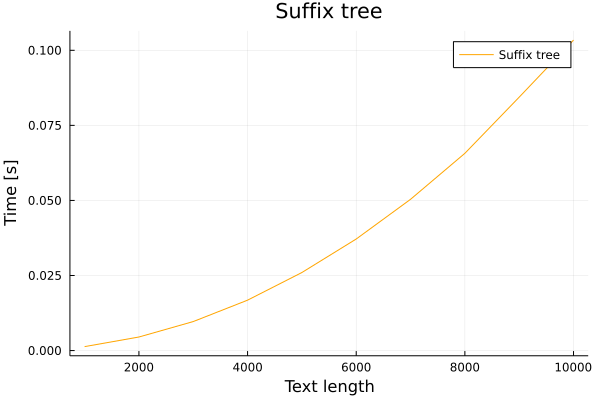

In [8]:
n = 1000:1000:10000
times = [
    bench.(n, SuffTree),
]
plot(
    n,
    times,
    label="Suffix tree",
    xlabel="Text length",
    ylabel="Time [s]",
    title="Suffix tree",
    color=:orange,
)